In [1]:
FRAME_SIZE = 150
HOP_RATIO = 0.1
N_FFT = 1024

In [2]:
import importlib
import modules.AudioProcessor
importlib.reload(modules.AudioProcessor)
from modules.AudioProcessor import AudioProcessor

audio_files = [
    './dataset/trimmed_crowd_talking.mp3',
    './dataset/trimmed_motor_riding.mp3',
    './dataset/trimmed_water_flowing.mp3'
]
ap = AudioProcessor(
    audio_files, 
    frame_size_ms=FRAME_SIZE, 
    hop_length_ratio=HOP_RATIO
    )
print(ap.frames.shape)
print(ap.class_ids.shape)
print(ap.timestamps.shape)

torch.Size([2664, 7200])
(2664,)
(2664,)


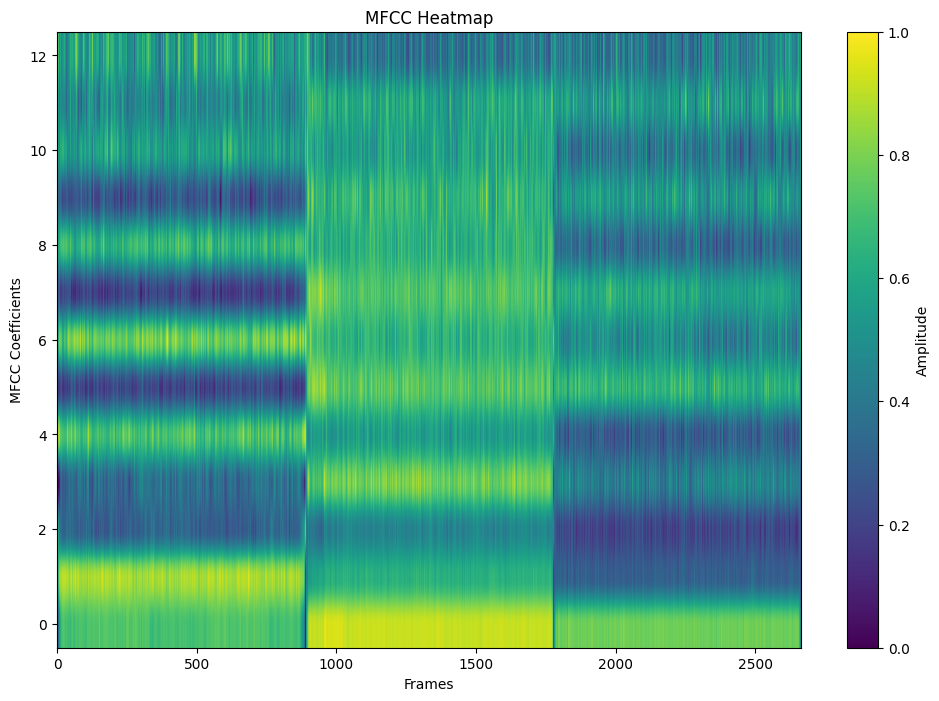

torch.Size([2664, 13])

In [3]:
import importlib
import modules.FeatureExtractor
importlib.reload(modules.FeatureExtractor)
from modules.FeatureExtractor import FeatureExtractor

fe = FeatureExtractor(n_fft=N_FFT)
fe.extract_mfcc(ap.frames)
fe.plot_mfccs()
fe.mfcc_features.shape

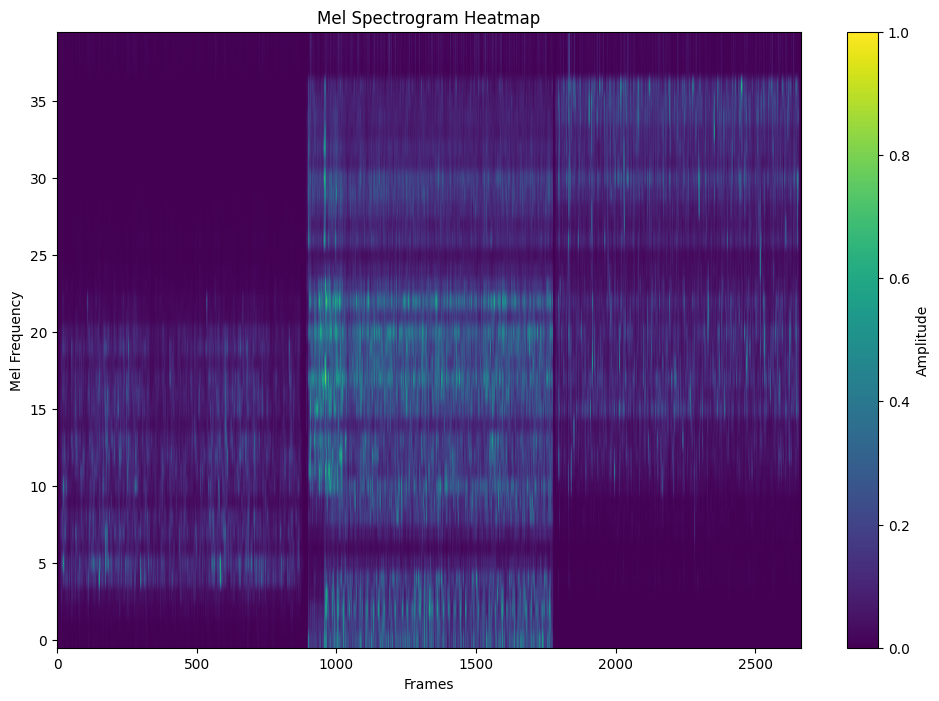

torch.Size([2664, 40])

In [4]:
fe.extract_melspectrogram(ap.frames)
fe.plot_melspectrogram()
fe.melspectrogram_features.shape

In [5]:
import warnings
import importlib
import modules.DatasetHandler
importlib.reload(modules.DatasetHandler)
from modules.DatasetHandler import DatasetHandler

warnings.filterwarnings("ignore")

dh = DatasetHandler(
    class_ids=ap.class_ids,
    timestamps=ap.timestamps, 
    mfccs=fe.mfcc_features, 
    mfsc=fe.melspectrogram_features,
    output_dir='output/no_pca' 
)
dh.generate_csv('all_features.csv')

In [6]:
important_mfccs = [i for i in range(13)]
important_mfsc = []
dh.save_selected_features(important_mfccs, important_mfsc, "mfccs_only.csv")
time_series_tensor = dh.generate_time_series('mfccs_only.csv', 'mfccs')

important_mfccs = []
important_mfsc = [i for i in range(40)]
dh.save_selected_features(important_mfccs, important_mfsc, "melspec_only.csv")
time_series_tensor = dh.generate_time_series('melspec_only.csv', 'melspec')

important_mfccs = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11]
important_mfsc = [i for i in range(14)] + [i for i in range(16, 35)]
dh.save_selected_features(important_mfccs, important_mfsc, "combined.csv")
time_series_tensor = dh.generate_time_series('combined.csv', 'combined')


In [7]:
import modules.ART2Clusterer
importlib.reload(modules.ART2Clusterer)
from modules.ART2Clusterer import ART2Clusterer
import pandas as pd

def cluster_dataset(i, filename, n_features, plot_name, vigilance, pca=False):
    magenta = "\033[35m"
    green = "\033[32m"
    end = "\033[0m"
    optimal_tag = f"{green}(Optimal){end}" if pca and filename == "mfccs" else ""
    print(f"{magenta}Clustering time series {i}{end} - {filename} features {optimal_tag}")

    df = pd.read_csv(f'output/{"" if pca else "no_"}pca/time_series_{i}/{filename}_{i}.csv')
    clusterer = ART2Clusterer(
        vigilance=vigilance, 
        n_features=n_features,
        time_series_index=i,
    )
    for index, row in df.iterrows():
        clusterer.fit_clusters(row)

    clusterer.write_to_csv()
    conf_matrix, acc = clusterer.calc_accuracy()
    print(f"{green}Accuracy:{end} {acc}")
    print(f"{green}Confusion Matrix:{end}\n{conf_matrix}")
    clusterer.plot_truth_vs_time(plot_name)

Clustering time series 0 - mfccs features 
Accuracy: 0.9988738738738738
Confusion Matrix:
[[235   0   0]
 [  0 310   1]
 [  0   0 342]]


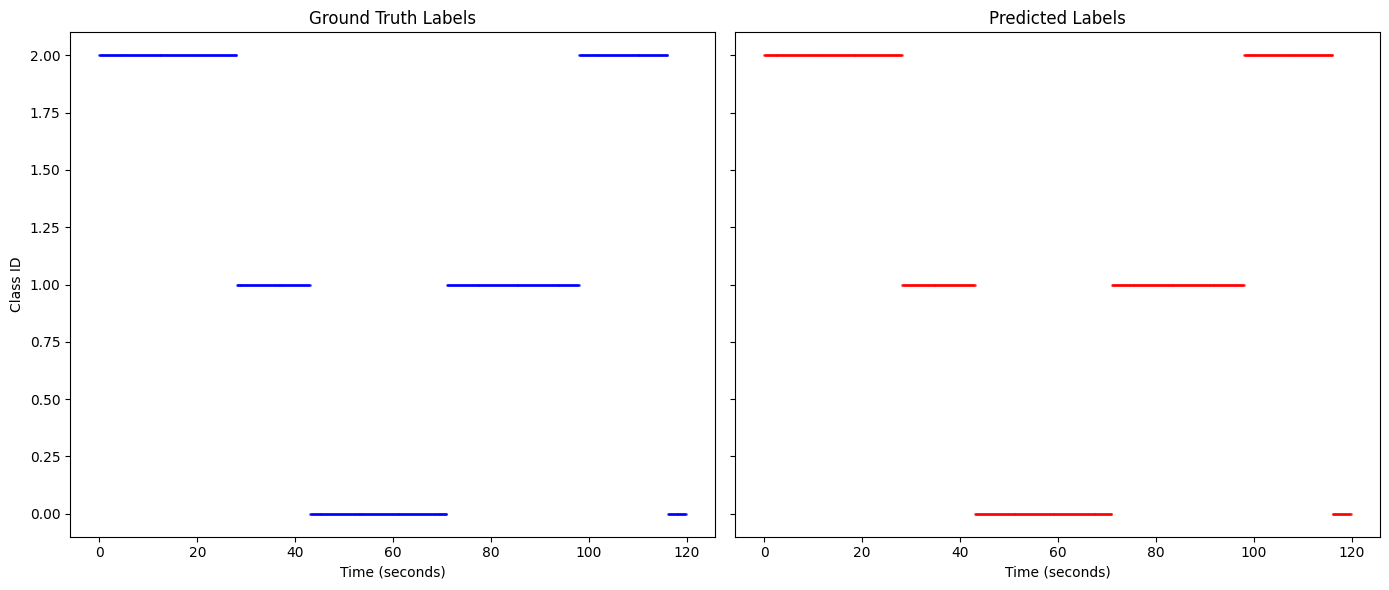

Clustering time series 0 - melspec features 
Accuracy: 0.7207207207207207
Confusion Matrix:
[[145   0   0]
 [ 20 189   1]
 [ 59   3 306]]


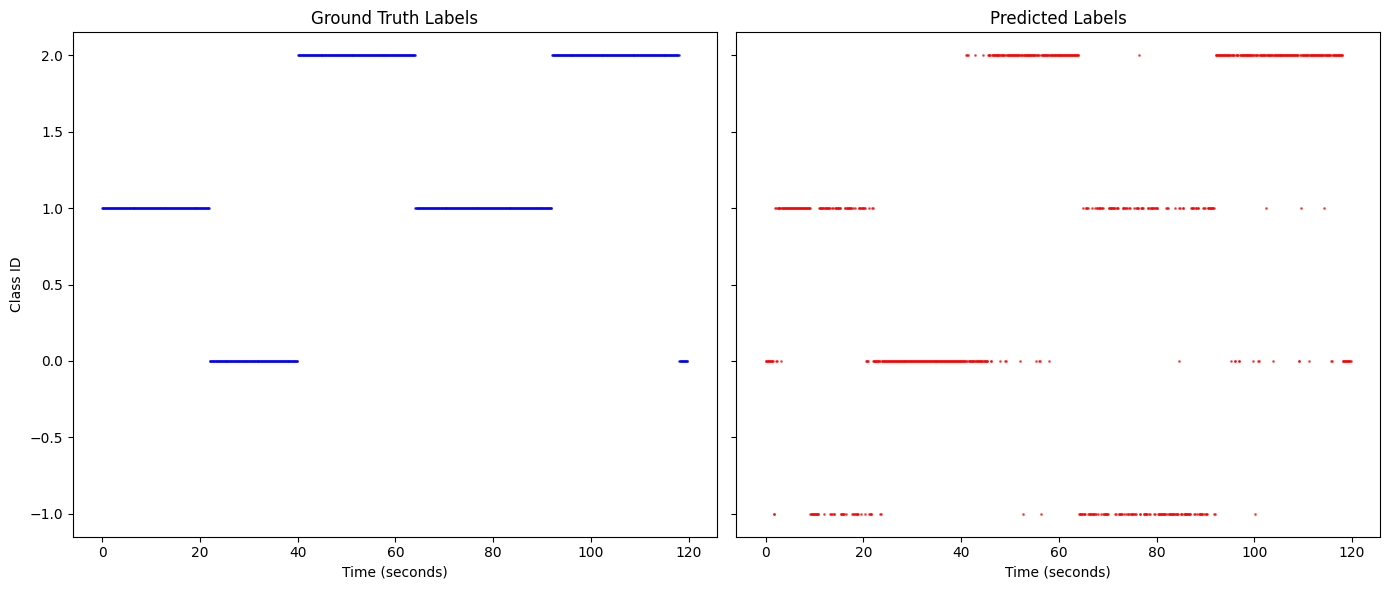

Clustering time series 0 - combined features 
Accuracy: 0.7882882882882883
Confusion Matrix:
[[326   0   0]
 [  0 165  12]
 [  0   0 209]]


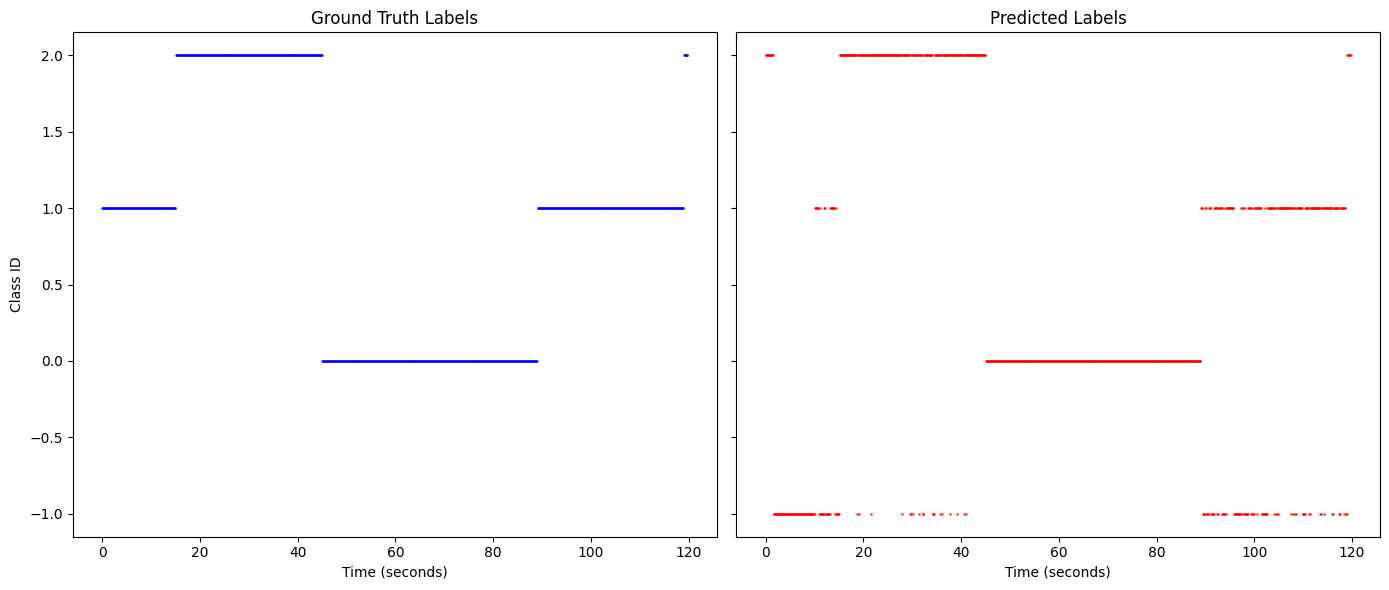

--------------------------------------------------------------------------------
Clustering time series 1 - mfccs features 
Accuracy: 0.9887387387387387
Confusion Matrix:
[[352   0   0]
 [  0 207   0]
 [  0   0 319]]


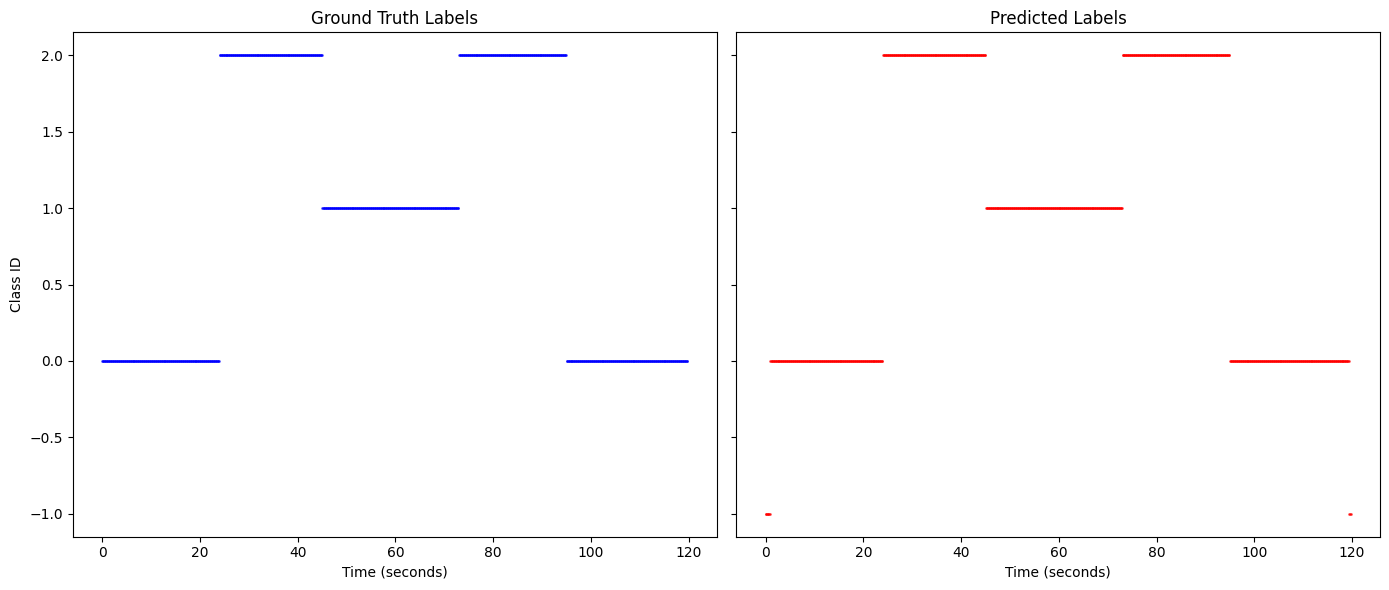

Clustering time series 1 - melspec features 
Accuracy: 0.9290540540540541
Confusion Matrix:
[[361   0   0]
 [  3 187   0]
 [ 19   2 277]]


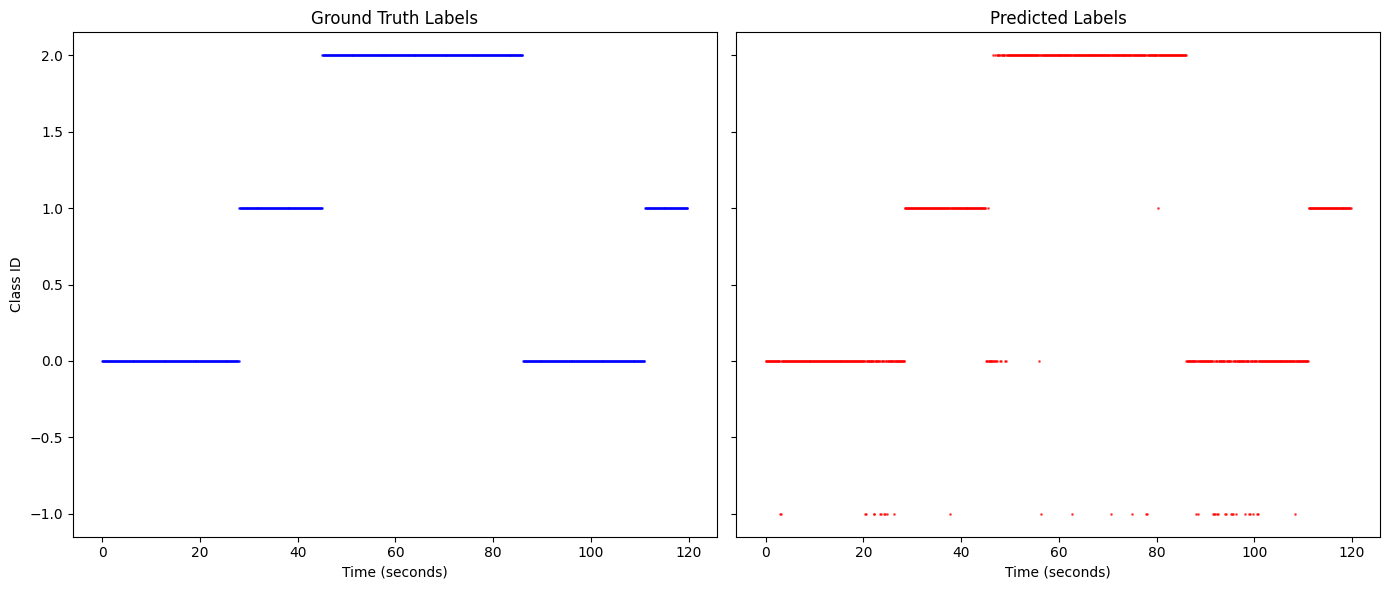

Clustering time series 1 - combined features 
Accuracy: 0.990990990990991
Confusion Matrix:
[[392   0   0]
 [  0 178   0]
 [  4   0 310]]


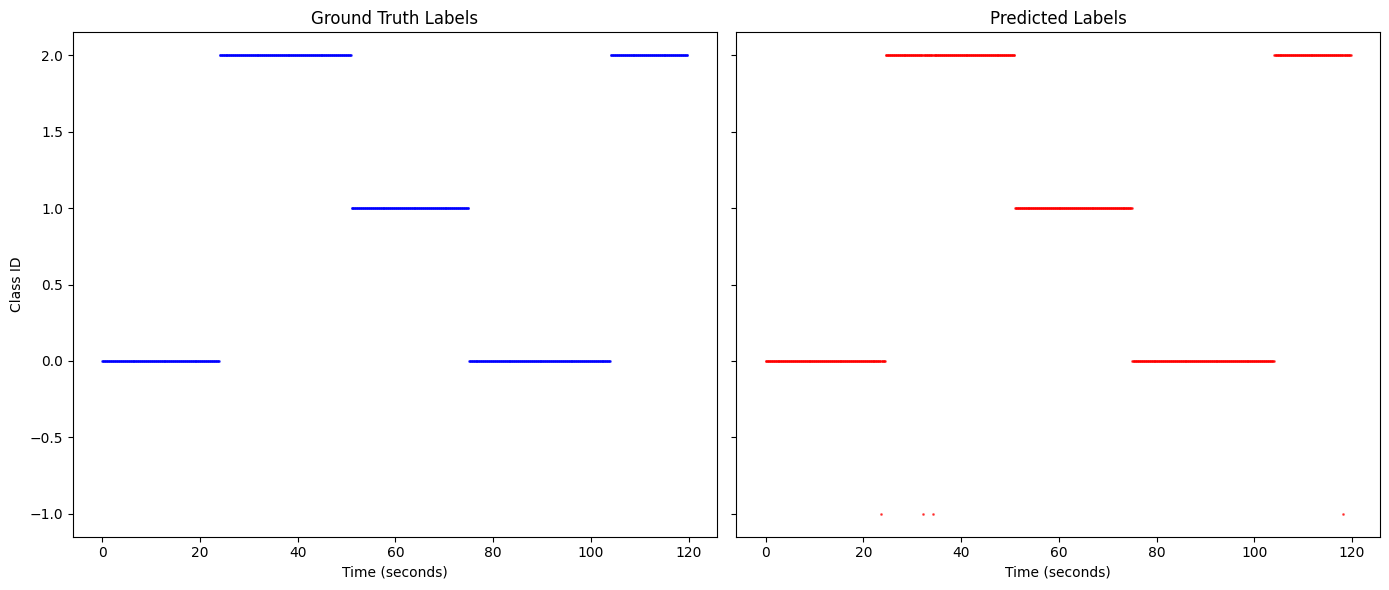

--------------------------------------------------------------------------------
Clustering time series 2 - mfccs features 
Accuracy: 0.9921171171171171
Confusion Matrix:
[[261   0   0]
 [  0 303   0]
 [  0   0 317]]


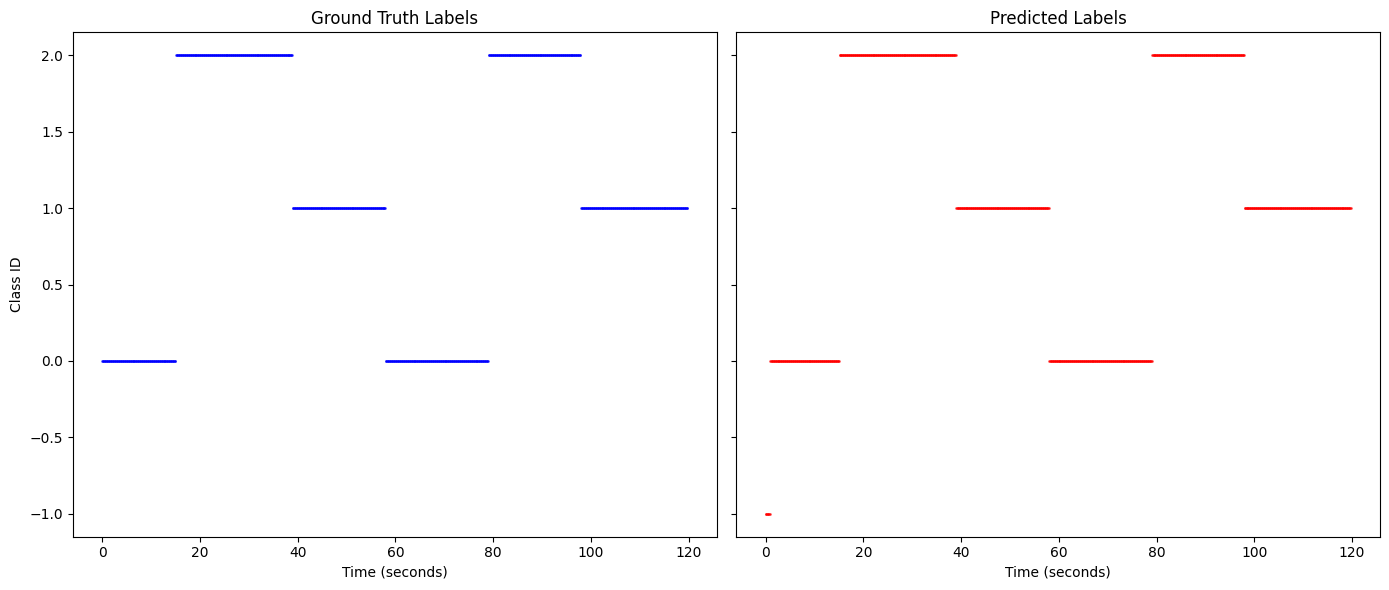

Clustering time series 2 - melspec features 
Accuracy: 0.8277027027027027
Confusion Matrix:
[[194   0 109]
 [  0 284   0]
 [  0   2 257]]


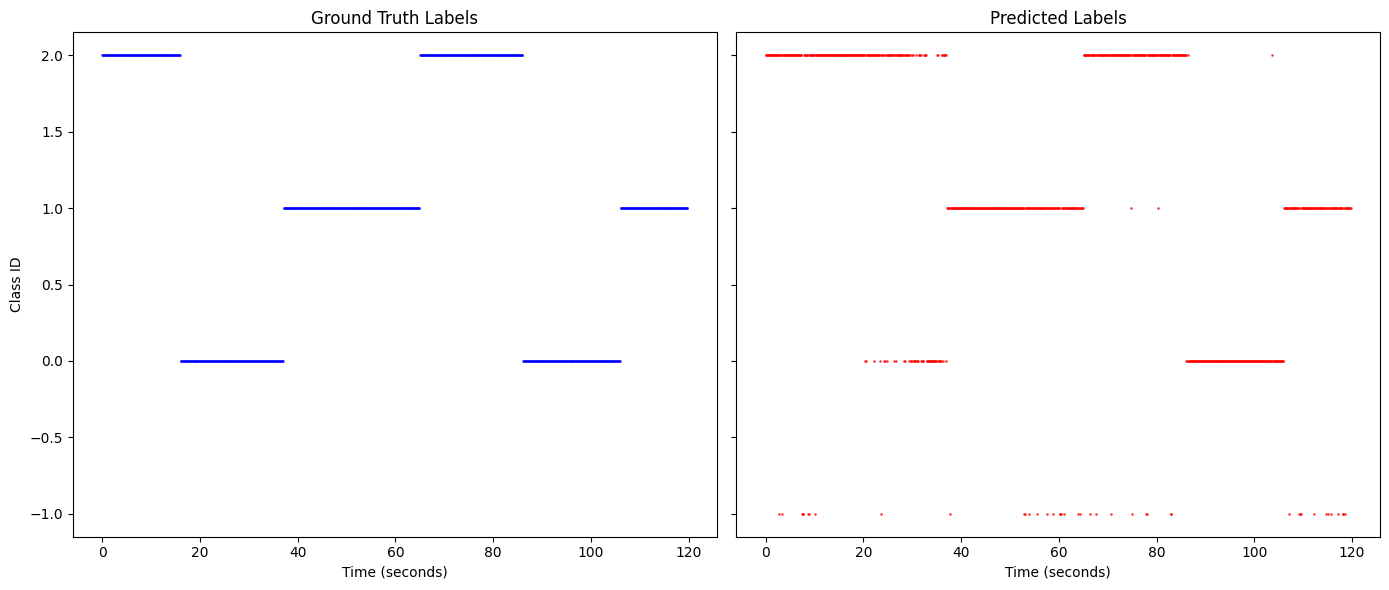

Clustering time series 2 - combined features 
Accuracy: 0.9808558558558559
Confusion Matrix:
[[325   0   1]
 [  0 171   5]
 [  0   0 375]]


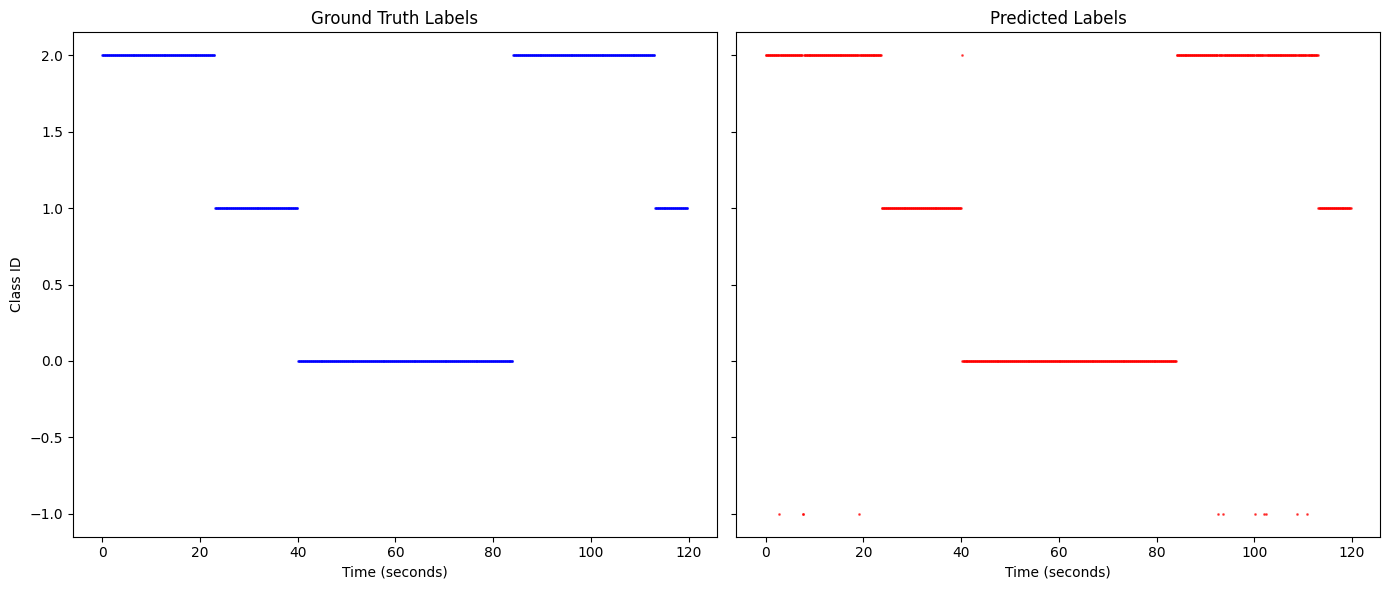

--------------------------------------------------------------------------------
Clustering time series 3 - mfccs features 
Accuracy: 0.9864864864864865
Confusion Matrix:
[[163   0   0]
 [  0 301   0]
 [  0   3 412]]


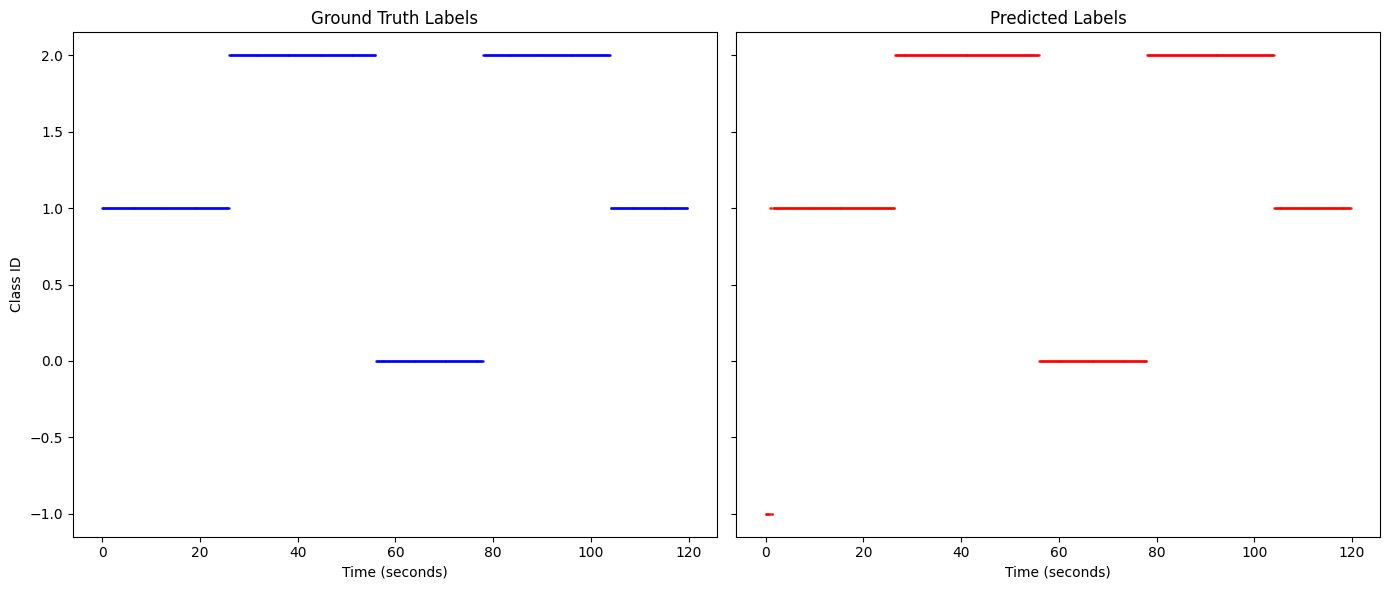

Clustering time series 3 - melspec features 
Accuracy: 0.9245495495495496
Confusion Matrix:
[[334   0   0]
 [  0 318   0]
 [ 27   1 169]]


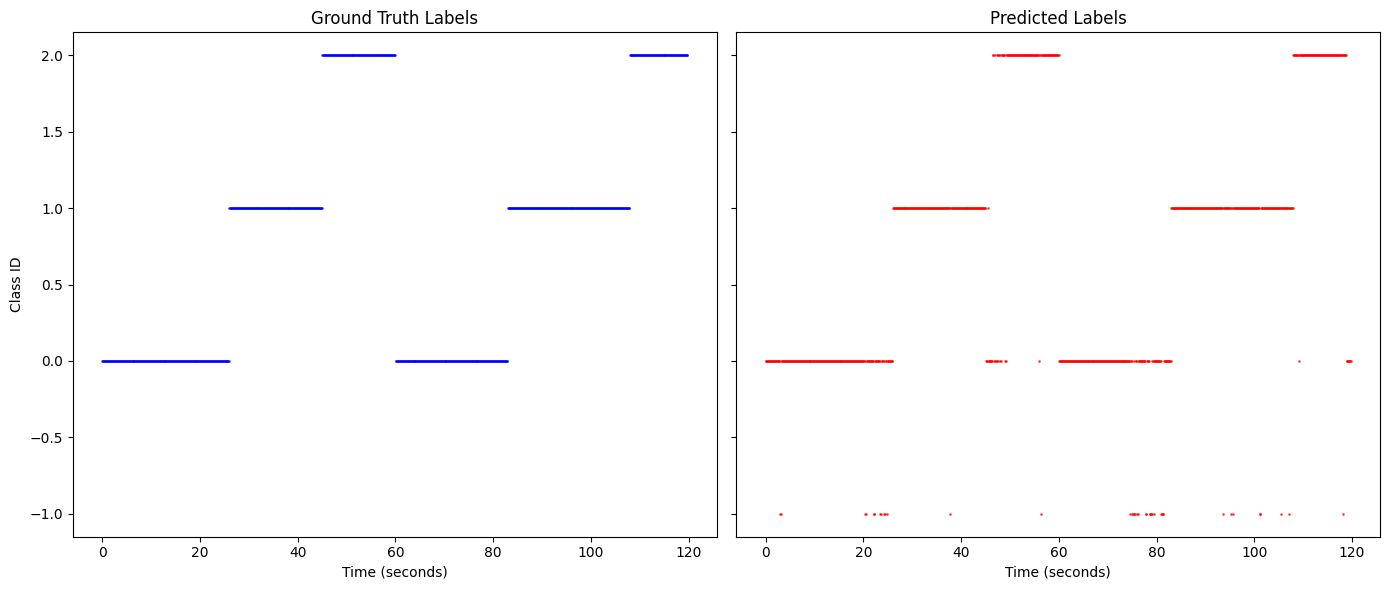

Clustering time series 3 - combined features 
Accuracy: 0.9797297297297297
Confusion Matrix:
[[177   0   0]
 [  0 363   0]
 [  2  11 330]]


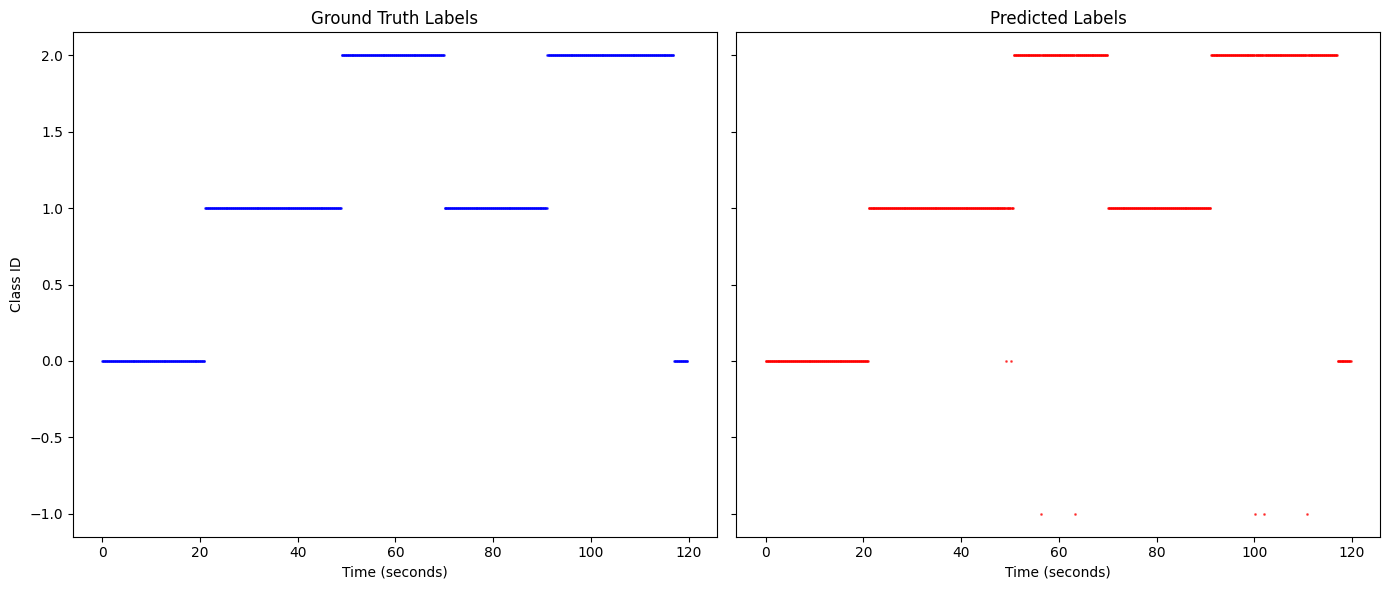

--------------------------------------------------------------------------------
Clustering time series 4 - mfccs features 
Accuracy: 0.990990990990991
Confusion Matrix:
[[312   0   0]
 [  0 266   0]
 [  0   0 302]]


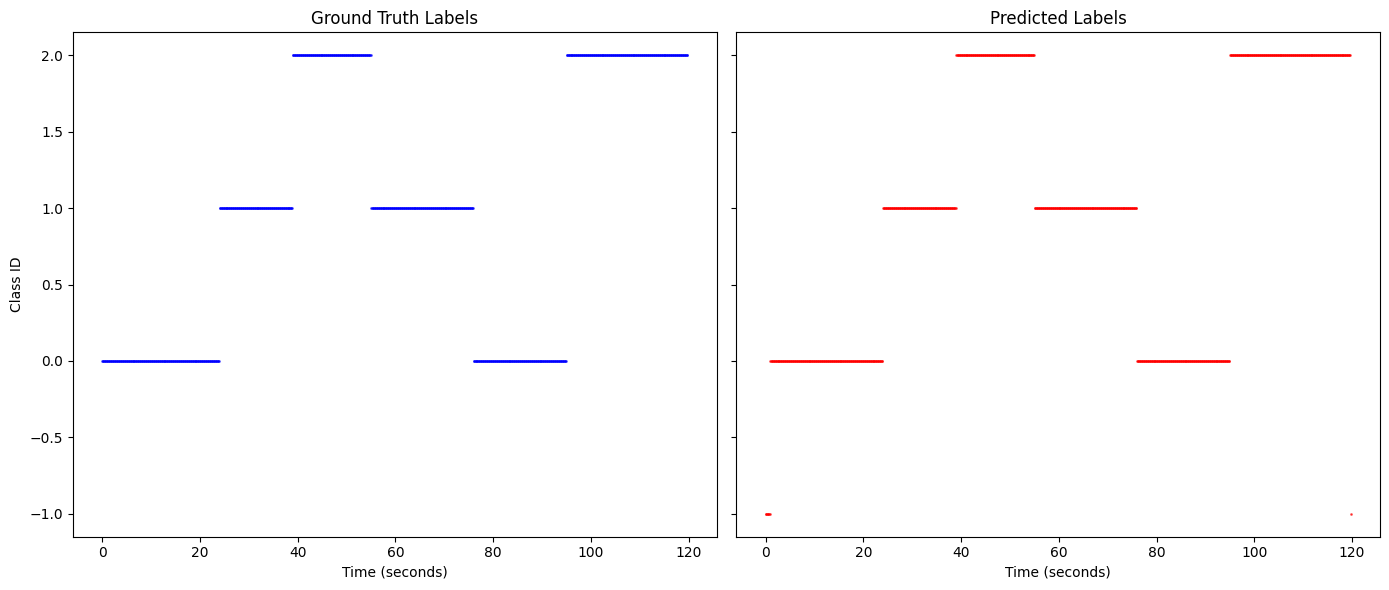

Clustering time series 4 - melspec features 
Accuracy: 0.9076576576576577
Confusion Matrix:
[[282   0   0]
 [  1 343   0]
 [ 54   0 181]]


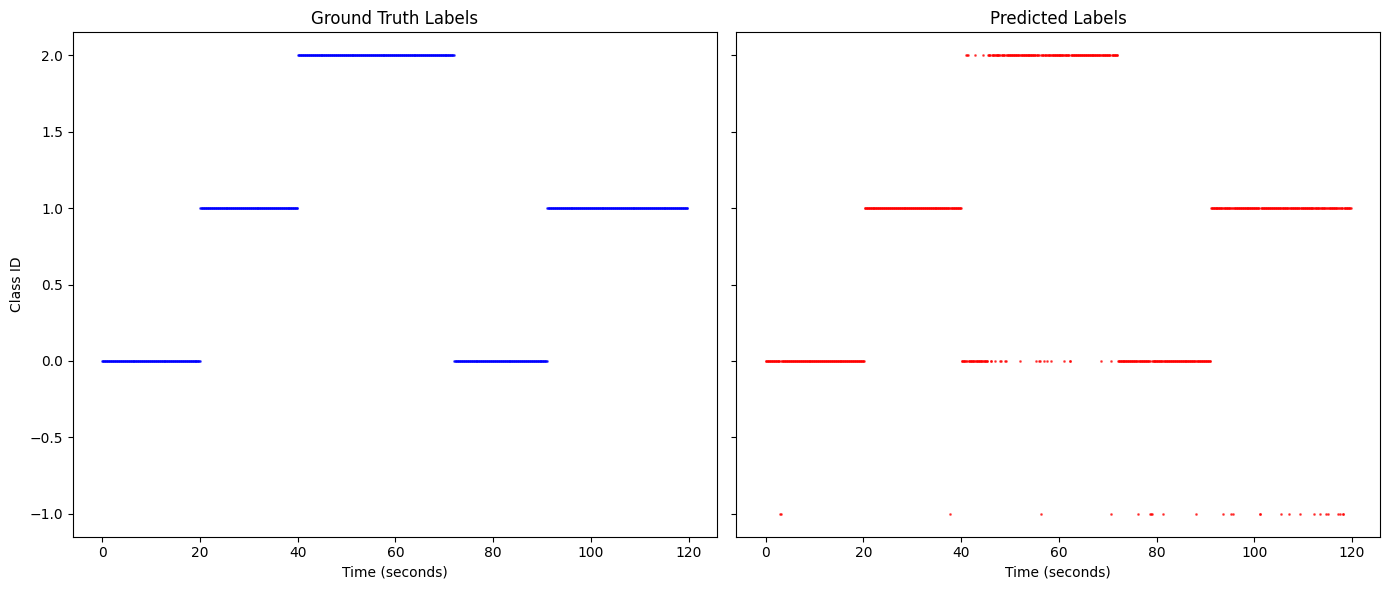

Clustering time series 4 - combined features 
Accuracy: 0.9954954954954955
Confusion Matrix:
[[331   0   0]
 [  0 371   0]
 [  0   0 182]]


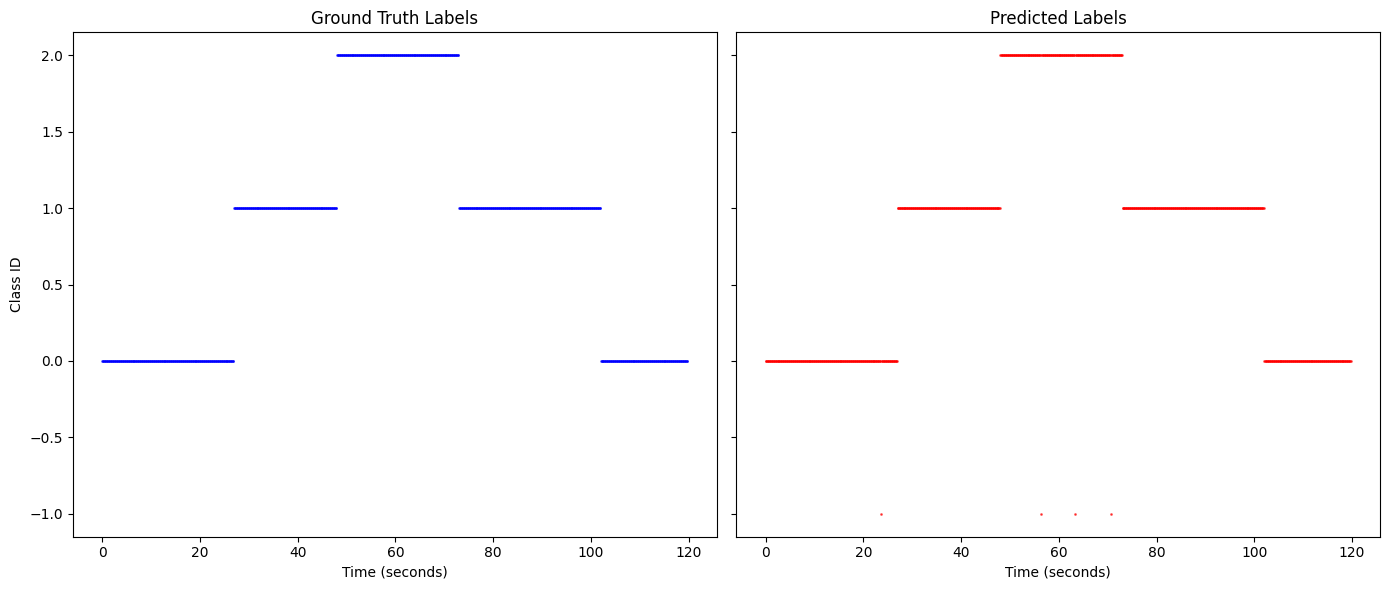

--------------------------------------------------------------------------------


In [8]:
MFCC_VIGILANCE = 0.5
MELSPEC_VIGILANCE = 0.95
COMBINED_VIGILANCE = 1.4

n_features = len(important_mfccs) + len(important_mfsc)
for i in range(5):
    cluster_dataset(i, 'mfccs', 13, 'MFCCs Only Ground Truth vs Predicted Labels', MFCC_VIGILANCE)
    cluster_dataset(i, 'melspec', 40, 'MFSCs Only Ground Truth vs Predicted Labels', MELSPEC_VIGILANCE)
    cluster_dataset(i, 'combined', n_features, 'Combined Ground Truth vs Predicted Labels', COMBINED_VIGILANCE)
    print('-'*80)

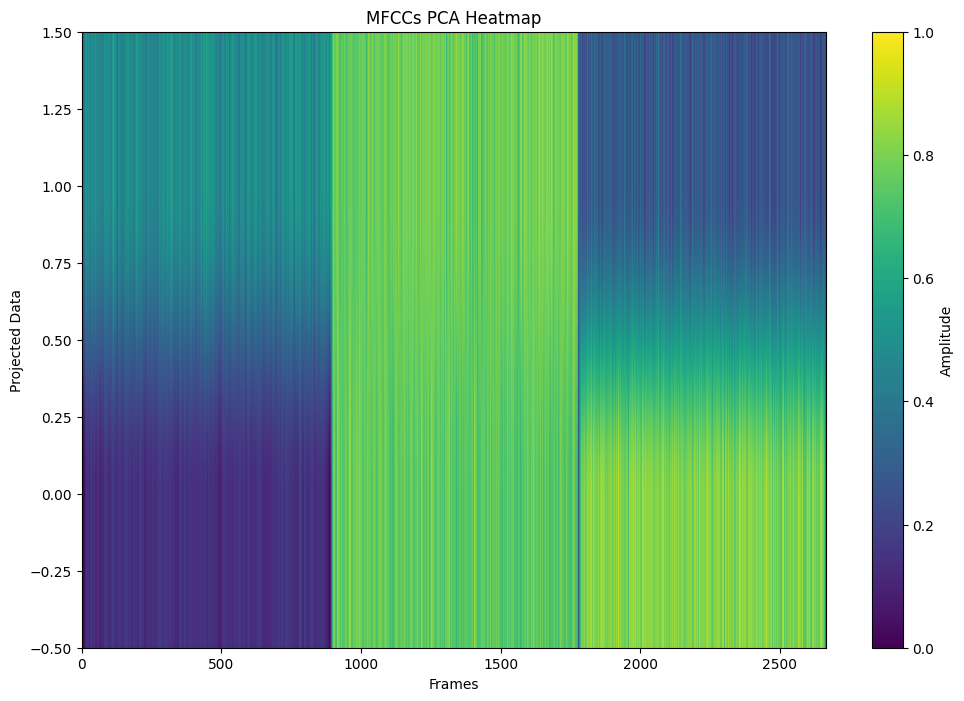

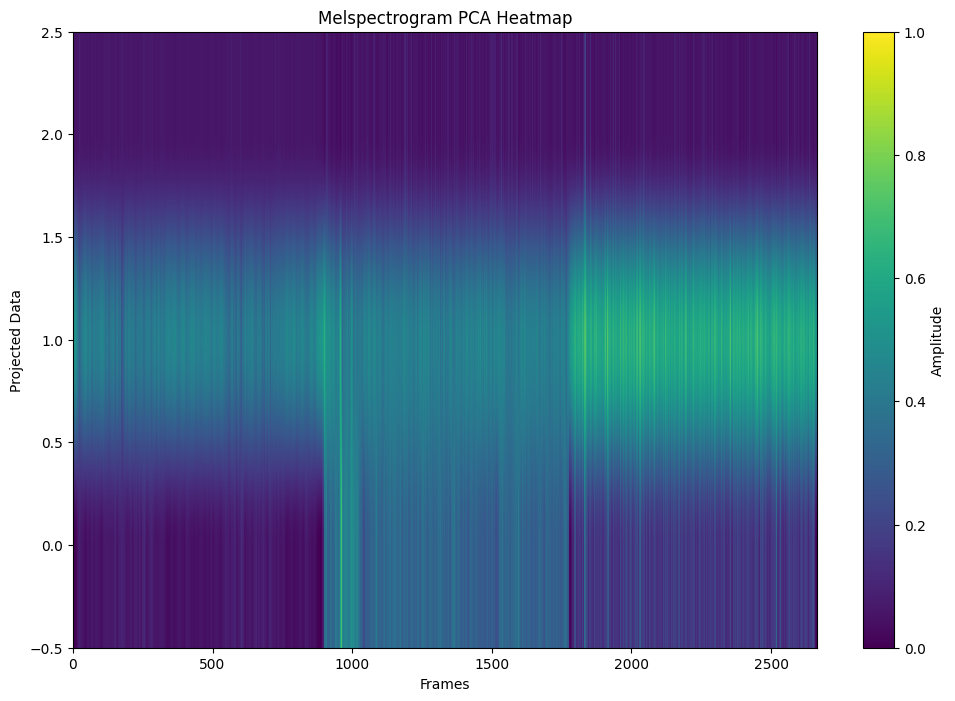

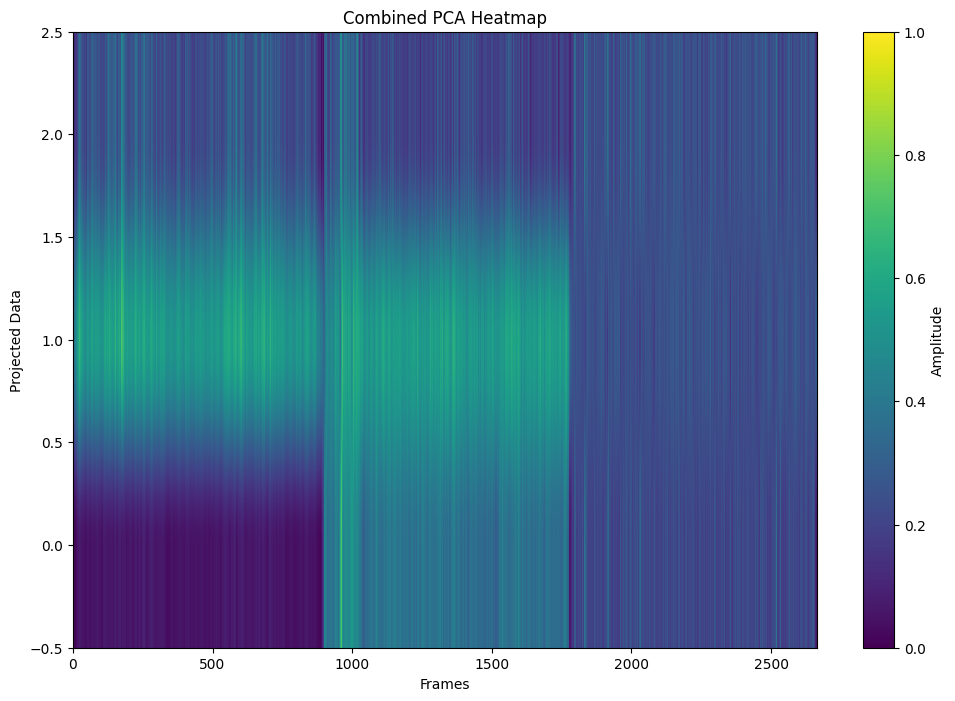

In [9]:
import modules.PCA
importlib.reload(modules.PCA)
from modules.PCA import PCA

mfccs_pca = PCA('output/no_pca/mfccs_only.csv', 0.6)
mfccs_pca.plot_projected_data("MFCCs PCA Heatmap")

mfsc_pca = PCA('output/no_pca/melspec_only.csv',  0.6)
mfsc_pca.plot_projected_data("Melspectrogram PCA Heatmap")

combined_pca = PCA('output/no_pca/combined.csv',  0.6)
combined_pca.plot_projected_data("Combined PCA Heatmap")
dh.set_output('output/pca')

dh.features = mfccs_pca.projected_data
dh.generate_csv("mfccs_only.csv", pca=True)
time_series_tensor = dh.generate_time_series('mfccs_only.csv', 'mfccs')

dh.features = mfsc_pca.projected_data
dh.generate_csv("melspec_only.csv", pca=True)
time_series_tensor = dh.generate_time_series('melspec_only.csv', 'melspec')

dh.features = combined_pca.projected_data
dh.generate_csv("combined.csv", pca=True)
time_series_tensor = dh.generate_time_series('combined.csv', 'combined')

# Optimal Clustering Results for PCA
Look at the graphs with only MFCC features for most optimal results

Clustering time series 0 - mfccs features (Optimal)
Accuracy: 0.9988738738738738
Confusion Matrix:
[[192   0   0]
 [  0 319   0]
 [  0   1 376]]


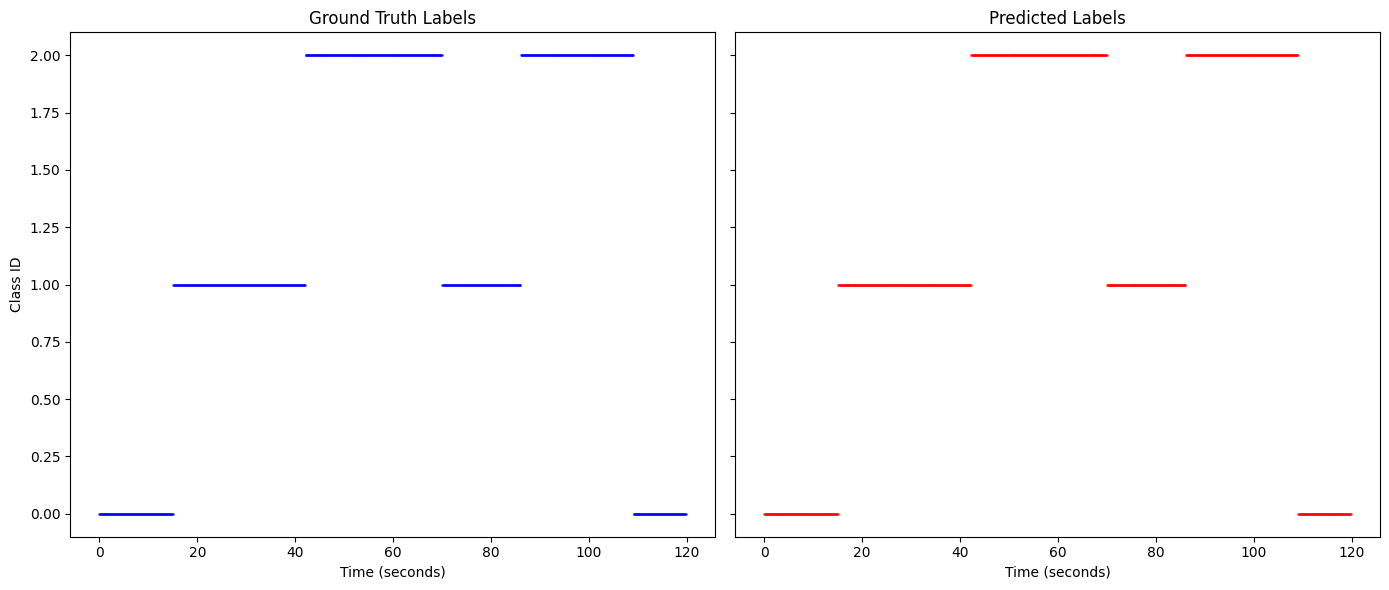

Clustering time series 0 - melspec features 
Accuracy: 0.6306306306306306
Confusion Matrix:
[[  0   0 287]
 [  2 244  29]
 [  0  10 316]]


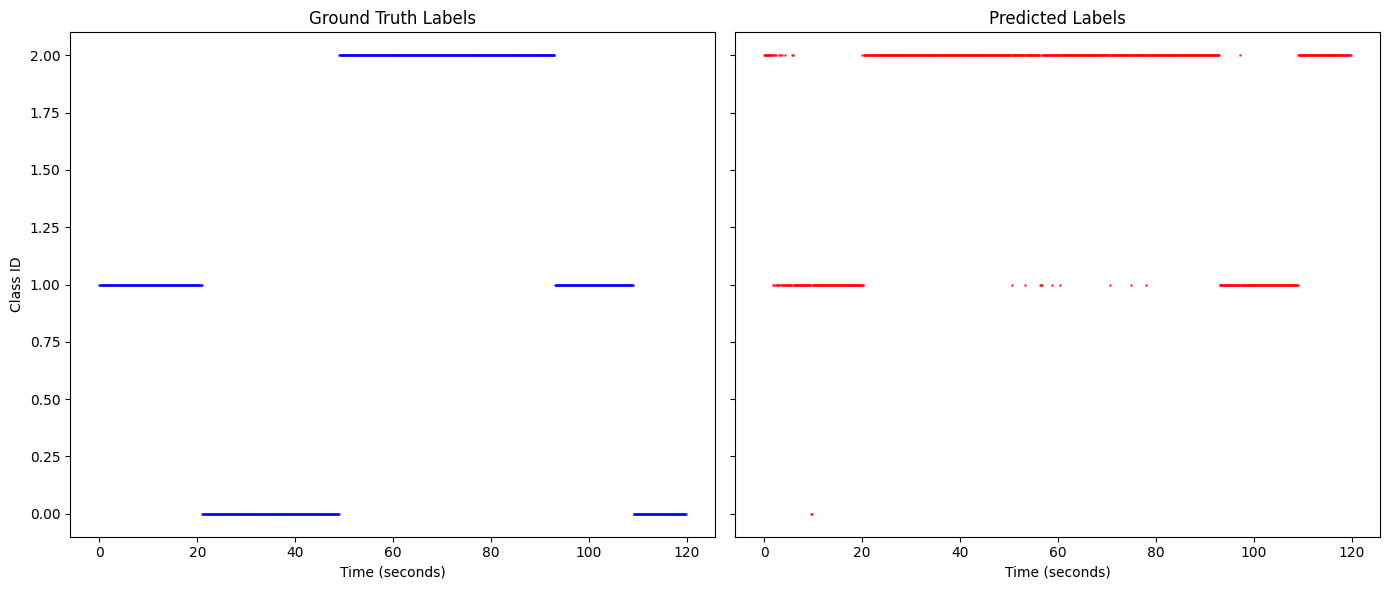

Clustering time series 0 - combined features 
Accuracy: 0.9864864864864865
Confusion Matrix:
[[275   0   0]
 [  2 242   0]
 [  9   1 359]]


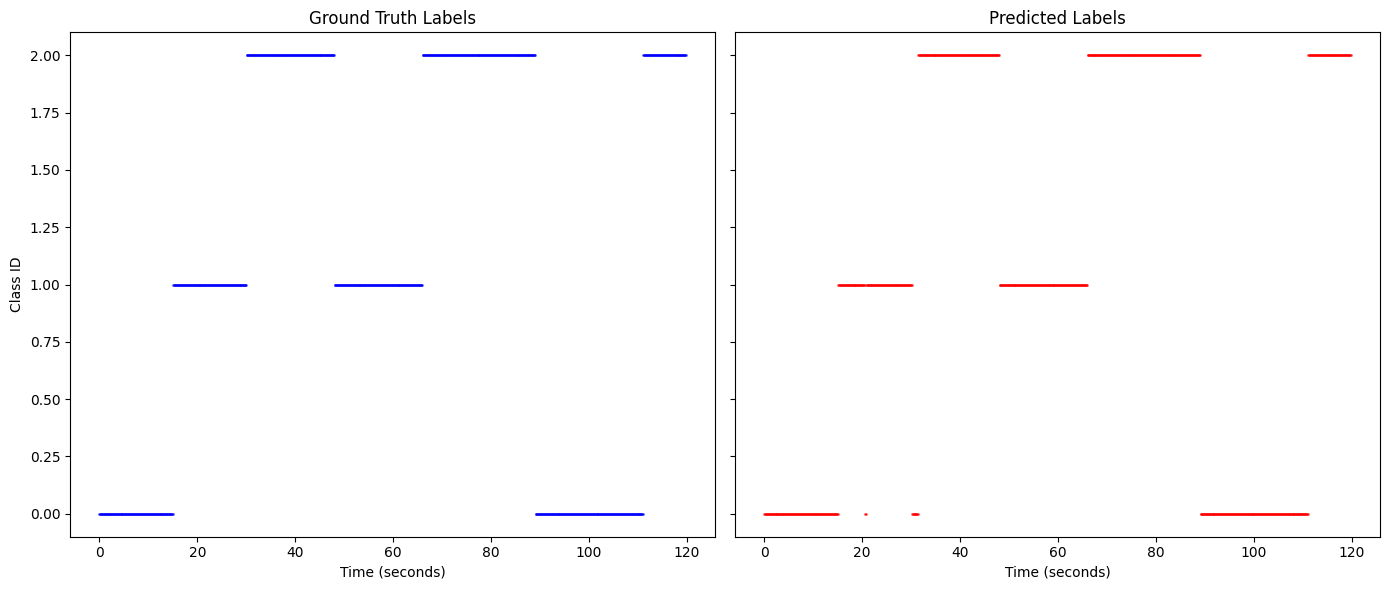

--------------------------------------------------------------------------------
Clustering time series 1 - mfccs features (Optimal)
Accuracy: 1.0
Confusion Matrix:
[[348   0   0]
 [  0 384   0]
 [  0   0 156]]


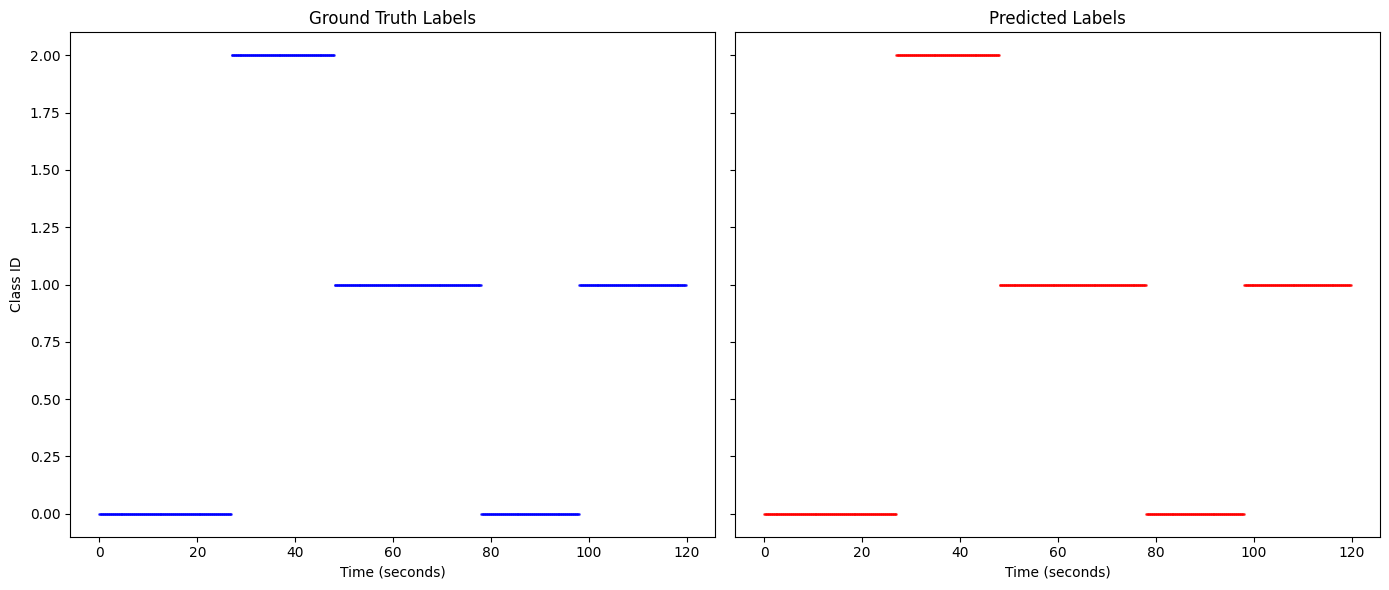

Clustering time series 1 - melspec features 
Accuracy: 0.6407657657657657
Confusion Matrix:
[[334   0   0]
 [ 23 234   2]
 [279  15   1]]


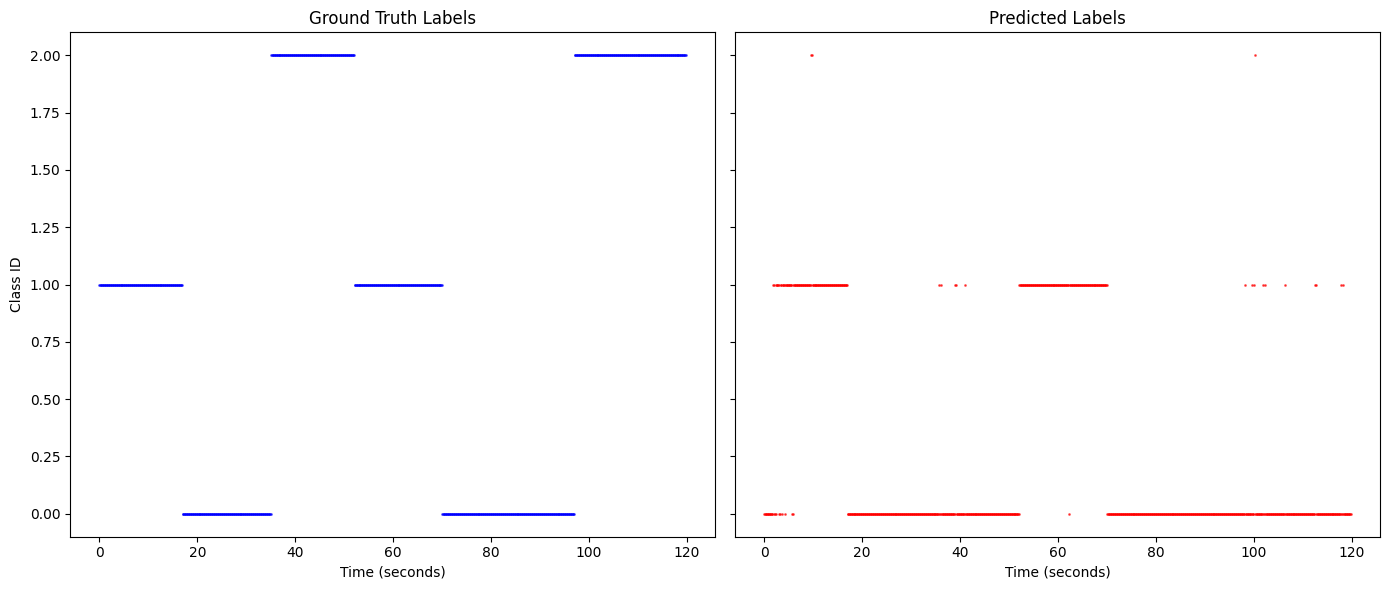

Clustering time series 1 - combined features 
Accuracy: 0.7083333333333334
Confusion Matrix:
[[199   1   0]
 [ 28 309   0]
 [217  10 121]]


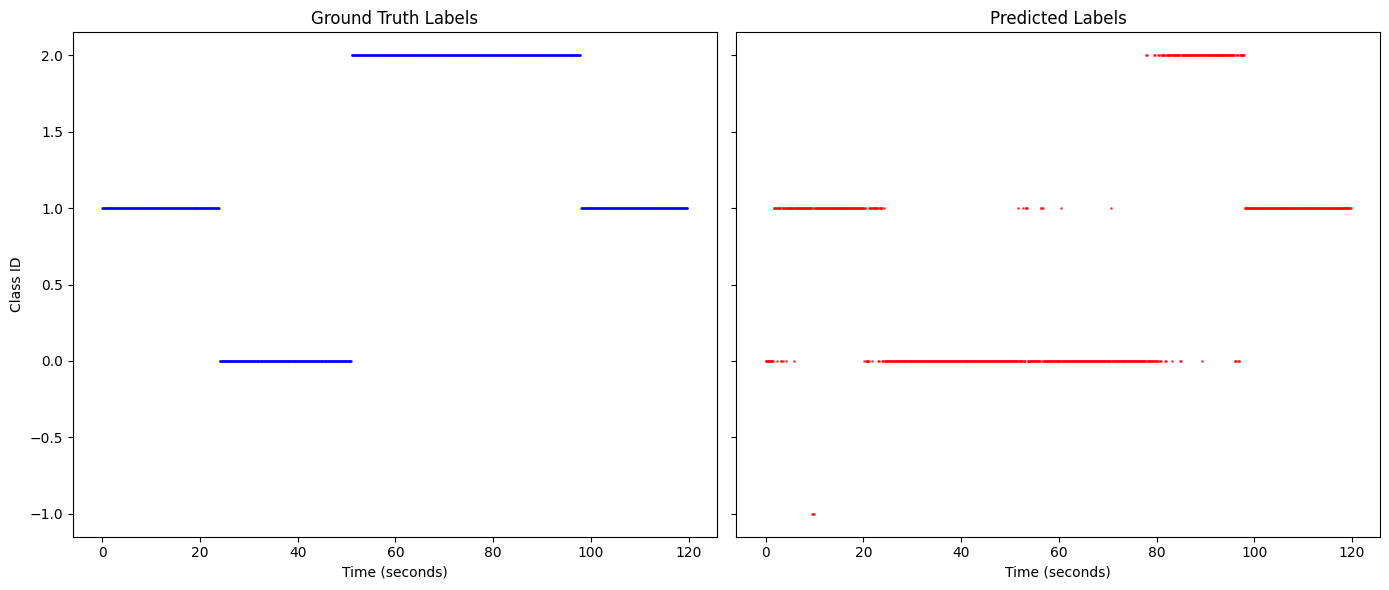

--------------------------------------------------------------------------------
Clustering time series 2 - mfccs features (Optimal)
Accuracy: 0.9921171171171171
Confusion Matrix:
[[222   0   0]
 [  6 335   0]
 [  0   0 324]]


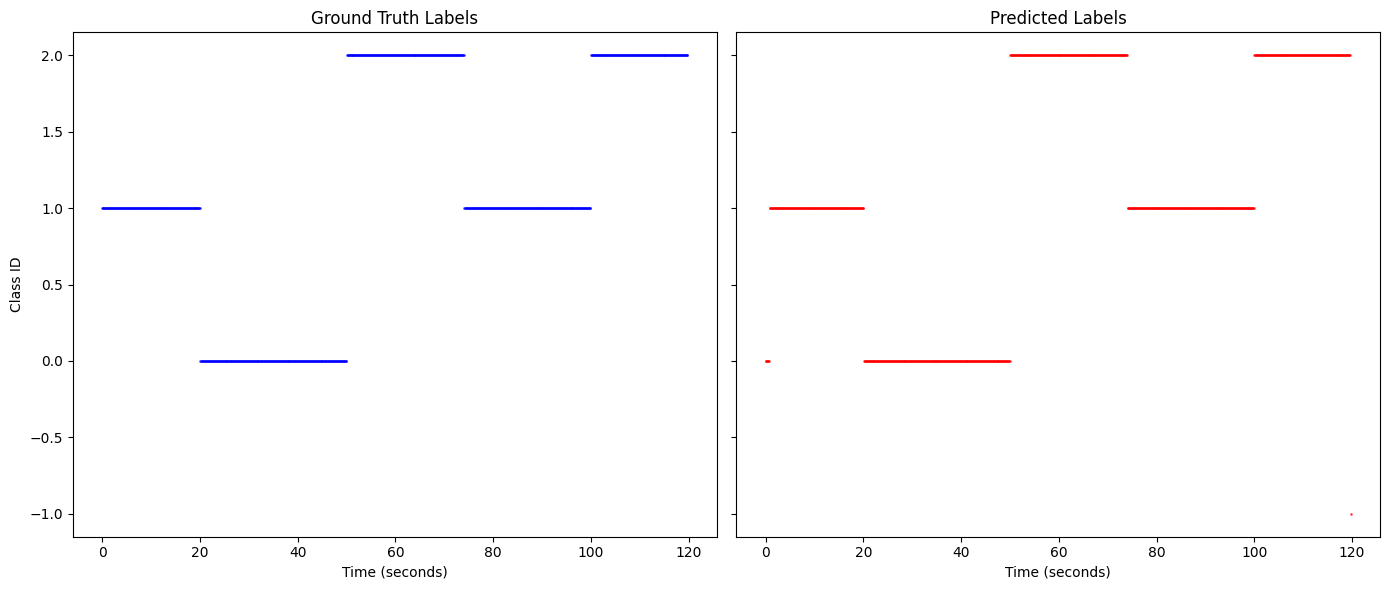

Clustering time series 2 - melspec features 
Accuracy: 0.5180180180180181
Confusion Matrix:
[[  0 169   0]
 [  0 377   0]
 [  0 259  83]]


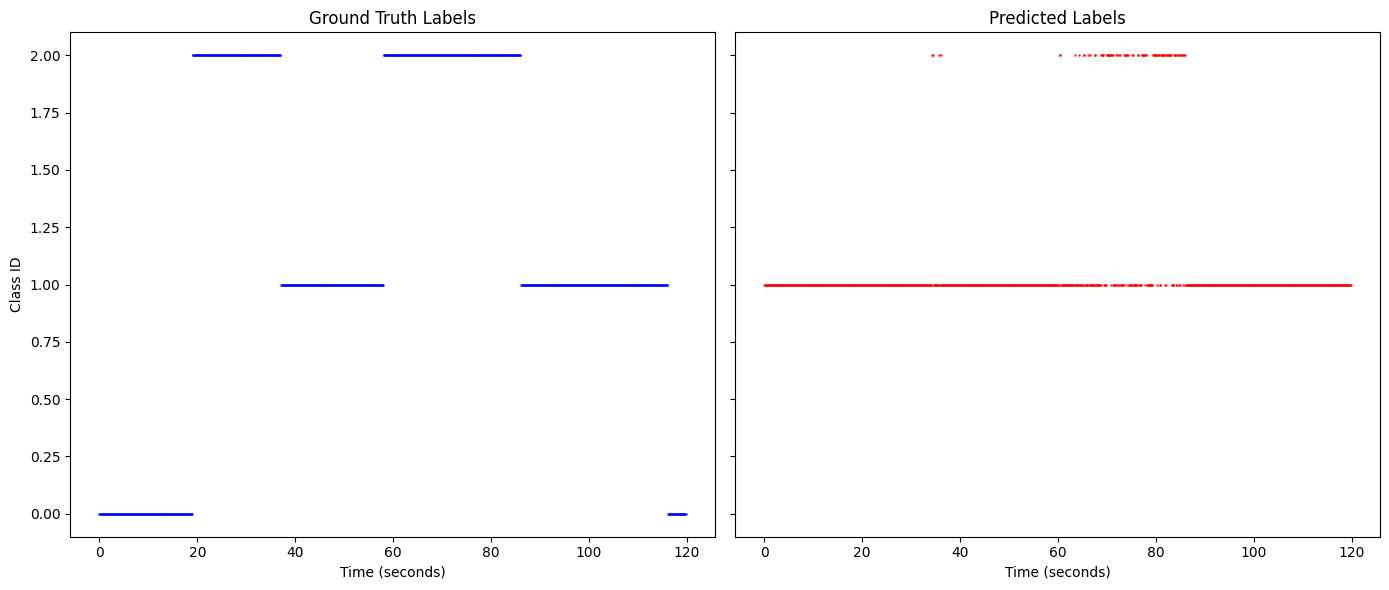

Clustering time series 2 - combined features 
Accuracy: 0.7353603603603603
Confusion Matrix:
[[333   0   0]
 [ 16 124   0]
 [218   0 196]]


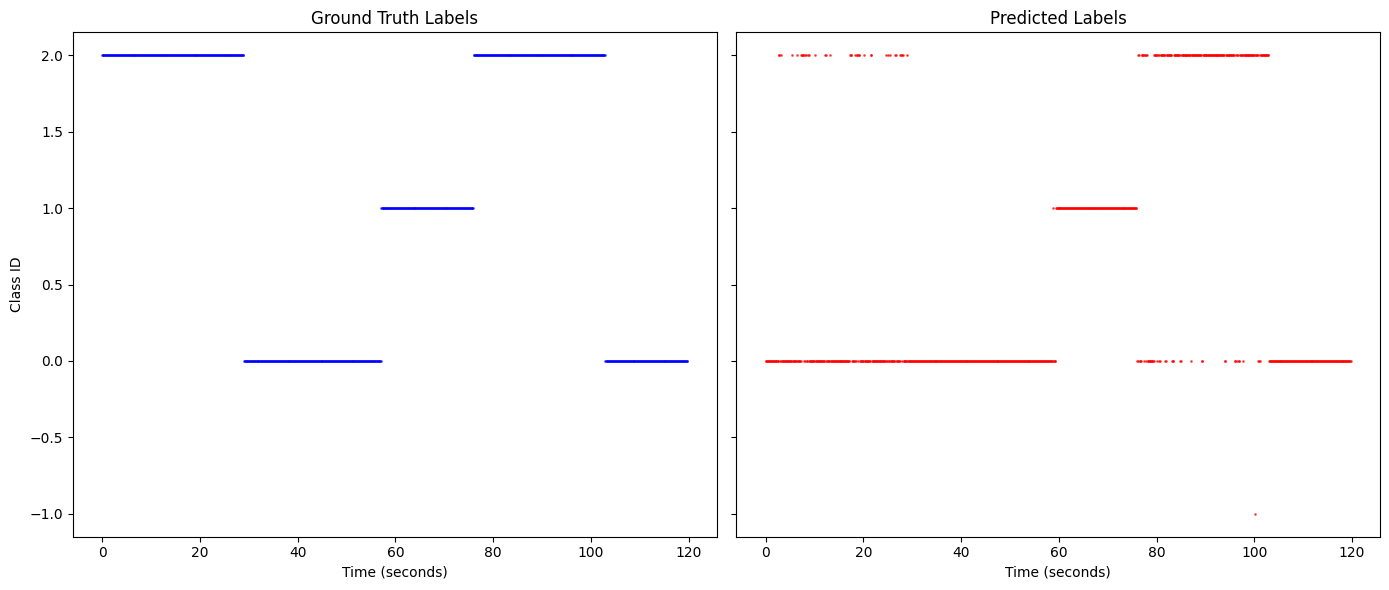

--------------------------------------------------------------------------------
Clustering time series 3 - mfccs features (Optimal)
Accuracy: 0.9932432432432432
Confusion Matrix:
[[274   0   0]
 [  6 215   0]
 [  0   0 393]]


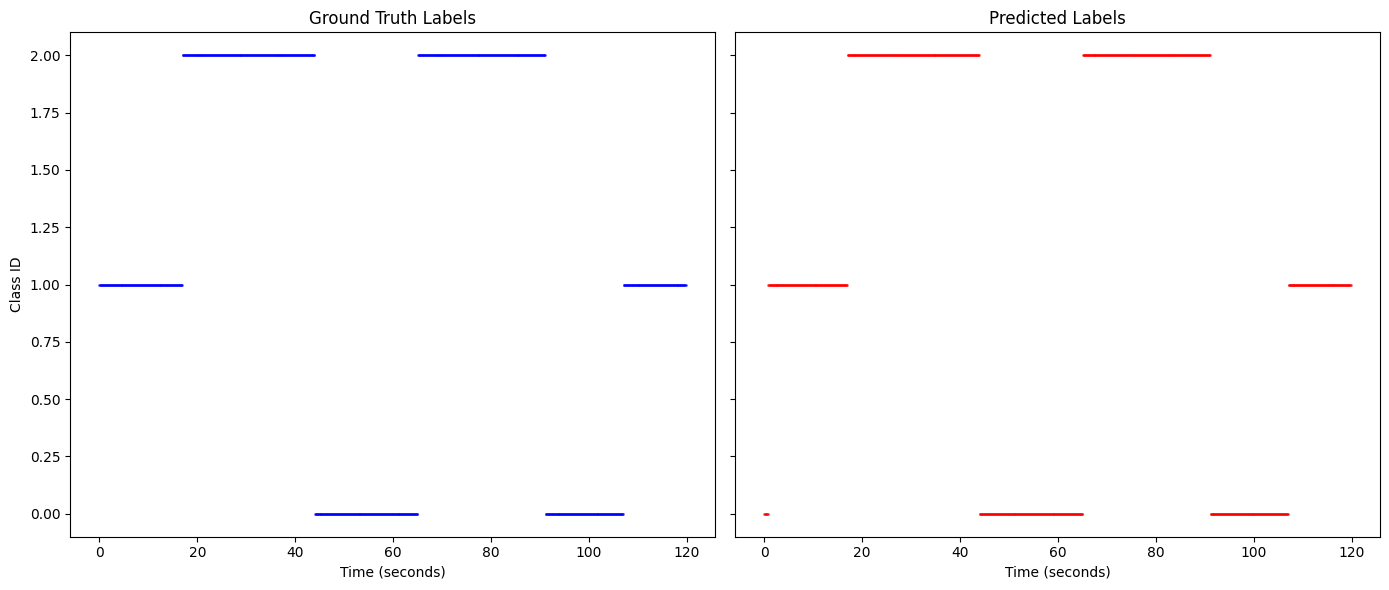

Clustering time series 3 - melspec features 
Accuracy: 0.7454954954954955
Confusion Matrix:
[[  0   0 163]
 [  0 368  39]
 [  0  24 294]]


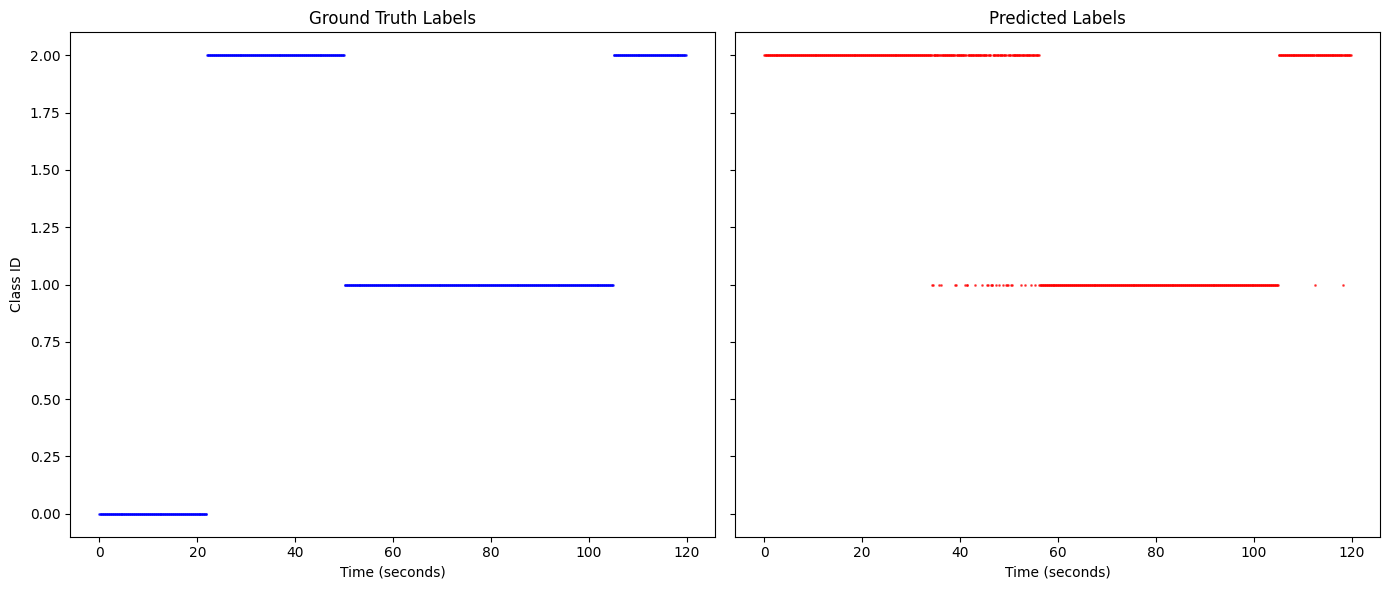

Clustering time series 3 - combined features 
Accuracy: 0.793918918918919
Confusion Matrix:
[[356   0   0]
 [ 38 303   0]
 [145   0  46]]


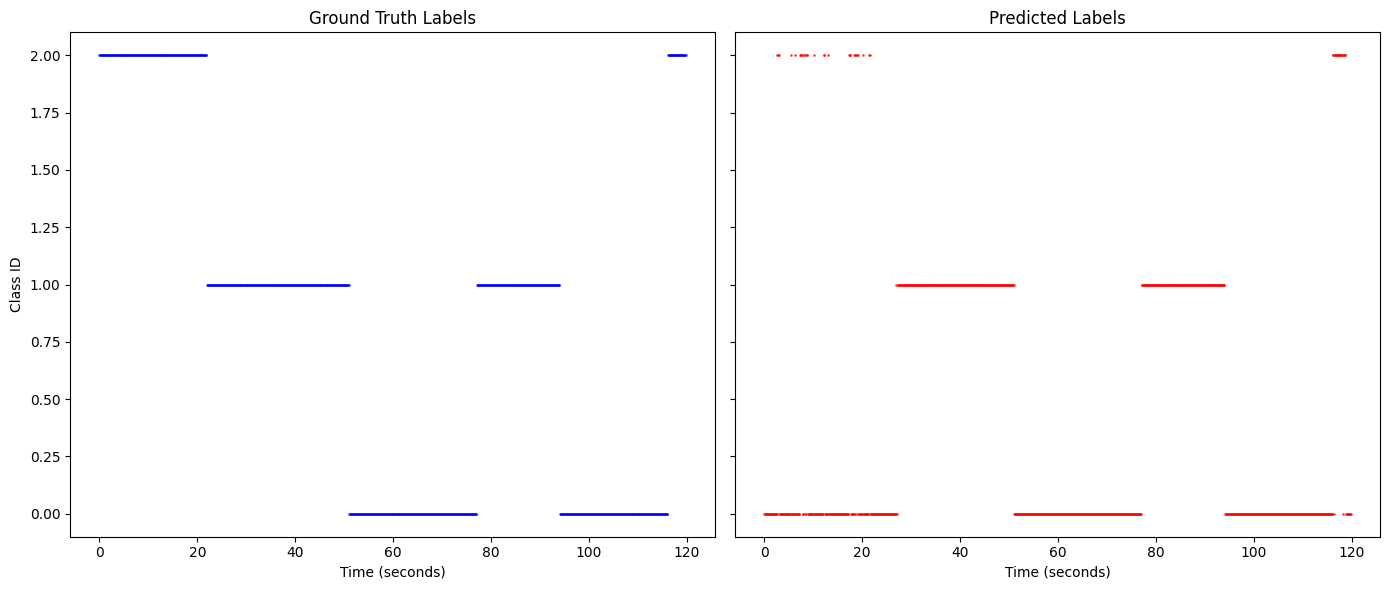

--------------------------------------------------------------------------------
Clustering time series 4 - mfccs features (Optimal)
Accuracy: 1.0
Confusion Matrix:
[[214   0   0]
 [  0 355   0]
 [  0   0 319]]


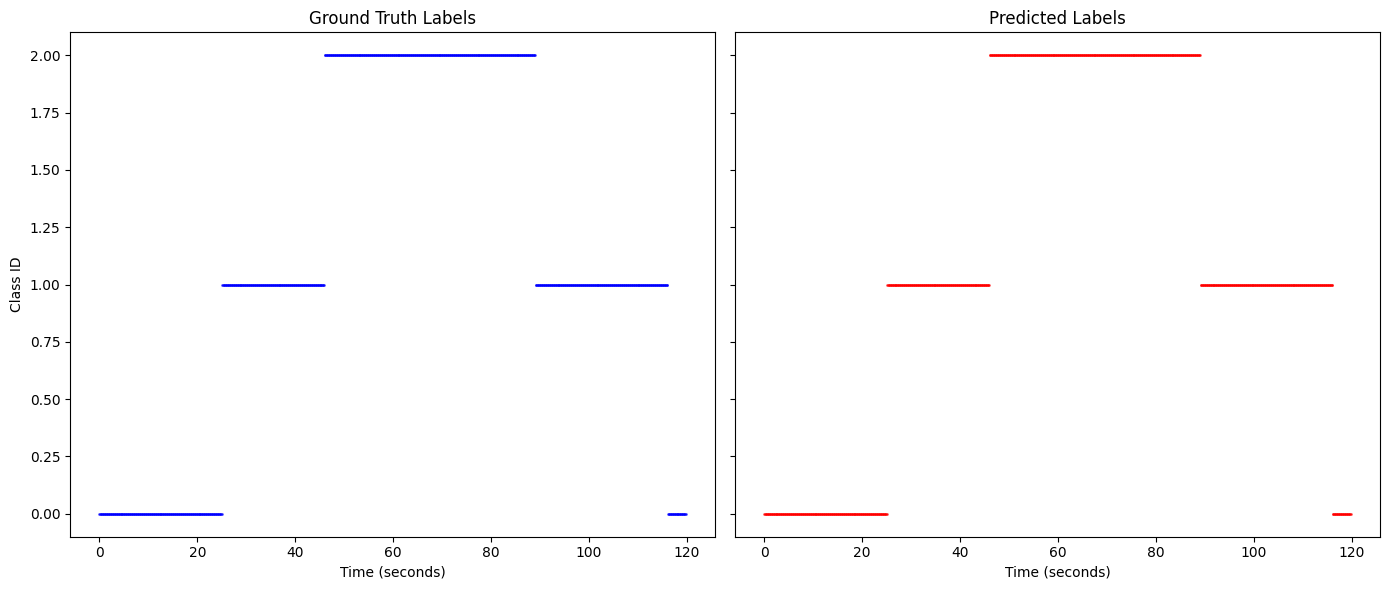

Clustering time series 4 - melspec features 
Accuracy: 0.45157657657657657
Confusion Matrix:
[[400   0   0]
 [304   0   0]
 [183   0   1]]


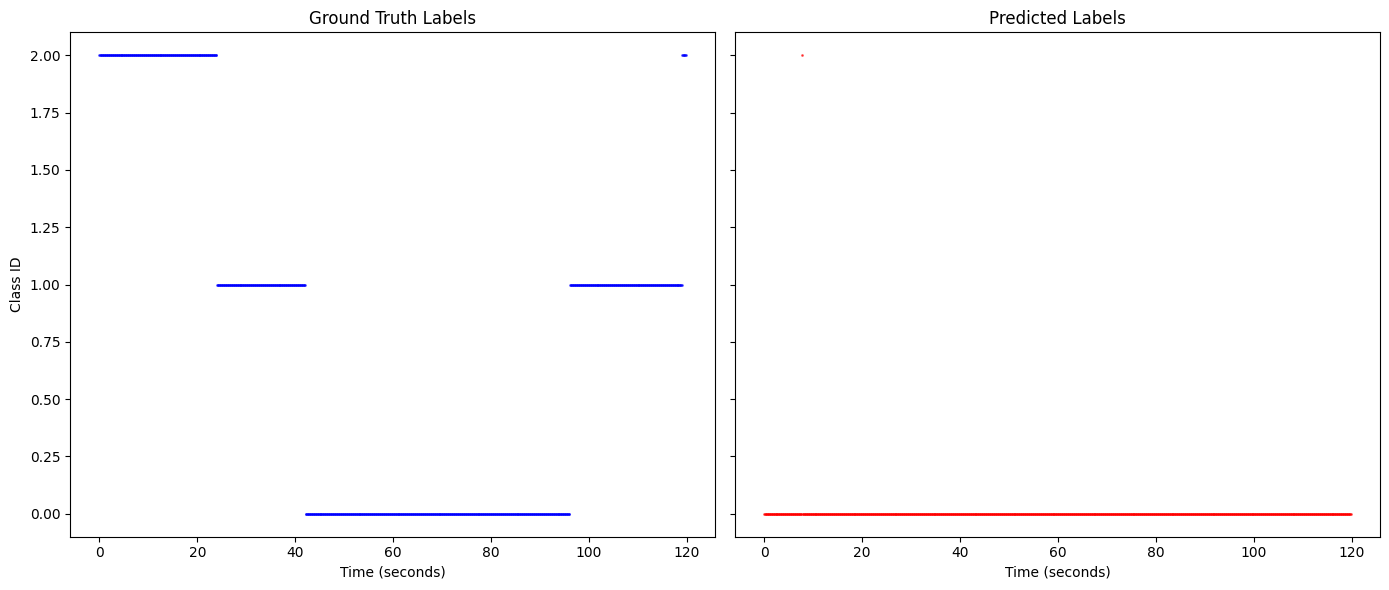

Clustering time series 4 - combined features 
Accuracy: 0.8265765765765766
Confusion Matrix:
[[264  47   0]
 [  0 345   3]
 [104   0 125]]


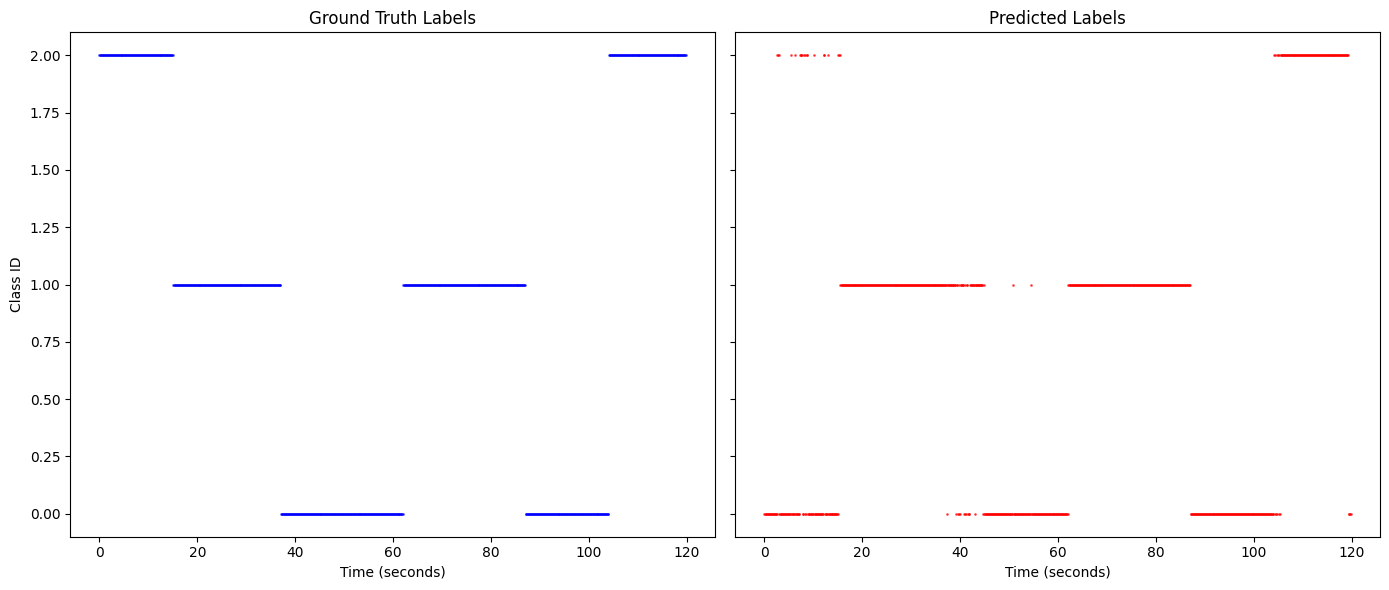

--------------------------------------------------------------------------------


In [10]:
MFCC_PCA_VIGILANCE = 0.15
MELSPEC_PCA_VIGILANCE = 0.26
COMBINED_PCA_VIGILANCE = 0.2

for i in range(5):
    cluster_dataset(i, 'mfccs', mfccs_pca.projected_data.shape[1], 'PCA MFCCs Only Ground Truth vs Predicted Labels', MFCC_PCA_VIGILANCE, True)
    cluster_dataset(i, 'melspec', mfsc_pca.projected_data.shape[1], 'PCA MFSCs Only Ground Truth vs Predicted Labels', MELSPEC_PCA_VIGILANCE, True)
    cluster_dataset(i, 'combined', combined_pca.projected_data.shape[1], 'PCA Combined Ground Truth vs Predicted Labels', COMBINED_PCA_VIGILANCE, True)
    print('-'*80)